https://medium.com/gitconnected/building-a-multi-agent-ai-system-with-langgraph-and-langsmith-6cb70487cd81

# Building Multi-Agent AI System Using LangGraph and LangSmith

Welcome to this comprehensive guide on building **multi-agent workflows** using LangGraph! In this notebook, we'll embark on a journey from a foundational ReAct agent to a sophisticated multi-agent customer support system. We'll explore core LangGraph concepts, leverage its pre-built libraries, and integrate advanced features like human-in-the-loop interactions and long-term memory.

## What is LangGraph?

LangGraph is a library designed to build stateful, multi-actor applications with LLMs, chains, and tools. It extends LangChain by allowing you to define sequences of calls (chains) more robustly, with cycles, conditional logic, and the ability to manage complex state transitions. This makes it ideal for creating agentic workflows where multiple `thinking` and `acting` steps are required, or where different specialized agents need to collaborate.

## Why Multi-Agent?

Multi-agent architectures are powerful for several reasons:

*   **Specialization & Modularity**: Instead of a single, monolithic agent trying to handle everything, a multi-agent system comprises smaller, specialized agents. Each agent is optimized for a specific task or domain (e.g., one for music queries, another for invoice details). This improves accuracy and performance within their specialized area.
*   **Flexibility & Scalability**: New capabilities can be added by simply integrating a new specialized agent, without needing to retrain or significantly modify existing agents. Agents can be quickly added, removed, or modified, making the system highly adaptable.
*   **Robustness**: If one agent fails or performs poorly in its specific task, it doesn't necessarily bring down the entire system, as other agents can still function. This contributes to a more resilient application.
*   **Complex Problem Solving**: Many real-world problems require different types of expertise. A multi-agent system can mimic human team collaboration, breaking down complex queries into sub-problems handled by the most appropriate expert agent.

## Our Customer Support Scenario

We will simulate a realistic customer support example for a digital music store. The agent will interact with the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), which contains comprehensive information about customers, invoices, and a music catalog.

Our final architecture will look something like this:

![Architecture Diagram](images/architecture.png) 

As you can see, the system starts with a **customer verification** step (human-in-the-loop), then **loads user preferences** from long-term memory. A **supervisor agent** then intelligently routes the query to the appropriate specialized sub-agent: either the **music catalog sub-agent** or the **invoice information sub-agent**. Finally, the system **saves any new user preferences** to long-term memory before providing a response.


For a deeper dive into LangGraph primitives and learning our framework, check out our [LangChain Academy](https://academy.langchain.com/courses/intro-to-langgraph)!


## Pre-work: Setup

Before we dive into building our multi-agent system, let's set up our environment. This involves loading necessary environment variables, connecting to our sample database, and initializing our memory stores.

#### Loading Environment Variables

To begin, we'll load our API keys and other configuration from a `.env` file. This keeps sensitive information out of our code. We'll be using OpenAI's models in this example, but LangGraph is model-agnostic, so you can easily swap `ChatOpenAI` with other `ChatModel` providers like Azure OpenAI, Anthropic, or Google Gemini.

Make sure your `.env` file includes all the keys specified in the `.env.example` file (e.g., `OPENAI_API_KEY`).

In [1]:
from dotenv import load_dotenv # Import function to load environment variables
from langchain_openai import ChatOpenAI # Import the OpenAI chat model
# from langchain_groq import ChatGroq

# Load environment variables from the .env file. The `override=True` argument
# ensures that variables from the .env file will overwrite existing environment variables.
load_dotenv(dotenv_path="local.env", override=True)

c:\Users\ytiam\notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# Initialize the ChatOpenAI model. We're using a specific model from Llama 3.3 series.
# This `model` object will be used throughout the notebook for all LLM interactions.
# llm = ChatGroq(model_name="openai/gpt-oss-120b", temperature=0)
llm = ChatOpenAI(model_name="gpt-5-nano", temperature=0)

In [4]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to Bemgali. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content='আমি প্রোগ্রামিং ভালোবাসি।', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 852, 'prompt_tokens': 32, 'total_tokens': 884, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 832, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CNNhpzqaEEUGNTV46qCmydVFxvbv4', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9111571b-9f1e-475d-8f51-2952d7e6b9be-0', usage_metadata={'input_tokens': 32, 'output_tokens': 852, 'total_tokens': 884, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 832}})

#### Loading Sample Customer Data (Chinook Database)

Our customer support agent will interact with a database to retrieve information. We'll use the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), a popular sample database that contains tables related to customer information, purchase history, and a music catalog (artists, albums, tracks, genres). This provides a rich dataset for our agent to query.

We'll load this SQLite database into an in-memory database for quick access during the notebook's execution. This avoids persistent file storage and simplifies setup.

In [33]:
import sqlite3 # Standard Python library for SQLite database interaction
import requests # Library for making HTTP requests (to download the SQL script)
from langchain_community.utilities.sql_database import SQLDatabase # LangChain utility to interact with SQL databases
from sqlalchemy import create_engine # SQLAlchemy function to create a database engine
from sqlalchemy.pool import StaticPool # SQLAlchemy connection pool class for in-memory databases

def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    # URL to the raw SQL script for the Chinook database
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    
    # Fetch the SQL script content from the URL
    response = requests.get(url)
    sql_script = response.text

    # Create an in-memory SQLite database connection.
    # `check_same_thread=False` is important for SQLAlchemy's StaticPool.
    connection = sqlite3.connect(":memory:", check_same_thread=False)
    
    # Execute the SQL script to populate the in-memory database with Chinook data
    connection.executescript(sql_script)
    
    # Create a SQLAlchemy engine for the in-memory SQLite database.
    # `creator=lambda: connection` tells SQLAlchemy how to get a new connection.
    # `poolclass=StaticPool` is used for in-memory databases, ensuring the same connection is reused.
    # `connect_args` are passed directly to the `sqlite3.connect` function.
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )

# Get the SQLAlchemy engine for our Chinook database
engine = get_engine_for_chinook_db()

# Create a LangChain SQLDatabase utility instance from the engine.
# This utility will help our agents interact with the database via SQL queries.
db = SQLDatabase(engine)

In [34]:
db

#### Setting up Short-Term and Long-Term Memory

Memory is a crucial component for building intelligent agents. LangGraph provides mechanisms to manage both short-term and long-term memory for our workflows.

*   **Short-Term Memory (Checkpointer)**: This preserves the state of a specific conversational thread. It allows the agent to maintain context and pick up where it left off within a *single conversation*. If a user's query requires multiple turns or involves human intervention, the checkpointer ensures the graph's state is saved and can be resumed.
    *   We use `MemorySaver` for in-memory short-term memory, suitable for demonstration purposes. For production, you'd typically use a persistent checkpointer (e.g., SQL, Redis).

*   **Long-Term Memory (InMemoryStore)**: This allows information to be stored and recalled *between conversations* or across different sessions for the same user. In our scenario, we'll use it to store user preferences, enabling personalization. For example, if a user mentions their favorite music genre, this information can be stored and used in future interactions.
    *   We use `InMemoryStore` for in-memory long-term storage. Similar to checkpointers, a persistent store (e.g., vector database, key-value store) would be used in a production environment.

In [35]:
from langgraph.checkpoint.memory import MemorySaver # For short-term memory (thread-level state persistence)
from langgraph.store.memory import InMemoryStore # For long-term memory (storing user preferences)

# Initializing `InMemoryStore` for long-term memory. 
# This store will hold user-specific data like music preferences across sessions.
in_memory_store = InMemoryStore()

# Initializing `MemorySaver` for short-term (thread-level) memory. 
# This checkpointer saves the graph's state after each step, allowing for restarts or interruptions within a thread.
checkpointer = MemorySaver()

## Part 1: Building ReAct Sub-Agents

Our multi-agent system will be composed of specialized sub-agents. We'll start by building two foundational ReAct agents, one from scratch to understand the core components, and another using LangGraph's pre-built utilities for quicker development.

### 1.1 Building a ReAct Agent from Scratch: The Music Catalog Sub-Agent

Our first sub-agent will be dedicated to handling customer inquiries related to the music store's catalog. This agent will utilize a set of tools to fetch information about artists, albums, tracks, and genres from the Chinook database.

The ReAct (Reasoning and Acting) framework is a popular pattern for building agents that interleave reasoning steps with acting steps (tool usage). The agent `reasons` about what tool to use and `acts` by calling that tool, then `observes` the result to `reason` again.

![Music Sub-Agent Architecture](images/music_subagent.png)

#### State

In LangGraph, the **State** is a critical concept. It acts as the shared memory of the agent, a data structure that is passed between the nodes of your graph. Each node receives the current state, performs its logic, and returns updates to the state, which then becomes the input for the next node. This continuous flow of information through the state allows the graph to maintain context and build up information as it progresses.

For our customer support agent, the state will track the following key elements:

1.  `customer_id`: A string representing the ID of the customer interacting with the agent. This is crucial for personalized queries (e.g., checking invoice history).
2.  `messages`: An annotated list of `AnyMessage` objects. This forms the conversation history, including user inputs, agent responses, and tool outputs. `add_messages` ensures that new messages are appended to the list, maintaining the conversational flow.
3.  `loaded_memory`: A string that will hold any user preferences or relevant information loaded from the long-term memory store. This allows the agent to tailor responses based on past interactions.
4.  `remaining_steps`: A `RemainingSteps` object. This is part of LangGraph's managed state and helps track the number of steps left before a recursion limit is hit, preventing infinite loops in cyclic graphs.

In [36]:
from typing_extensions import TypedDict # For defining dictionaries with type hints
from typing import Annotated, List # For type hinting lists and adding annotations
from langgraph.graph.message import AnyMessage, add_messages # For managing messages in the graph state
from langgraph.managed.is_last_step import RemainingSteps # For tracking recursion limits

class State(TypedDict):
    """Represents the state of our LangGraph agent."""
    # customer_id: Stores the unique identifier for the current customer.
    customer_id: str
    
    # messages: A list of messages that form the conversation history.
    # Annotated with `add_messages` to ensure new messages are appended rather than overwritten.
    messages: Annotated[list[AnyMessage], add_messages]
    
    # loaded_memory: Stores information loaded from the long-term memory store, 
    # typically user preferences or historical context.
    loaded_memory: str
    
    # remaining_steps: Used by LangGraph to track the number of allowed steps 
    # to prevent infinite loops in cyclic graphs.
    remaining_steps: RemainingSteps 

#### Tools

Tools are external functionalities that an LLM can invoke to extend its capabilities beyond pure text generation. These can be APIs, database queries, or any arbitrary Python function. In our music catalog sub-agent, we'll define a set of tools that interact with the Chinook database to fetch music-related information.

We use LangChain's `@tool` decorator to easily expose Python functions as tools that our LLM can learn to use. The decorator automatically generates a schema that the LLM can understand, allowing it to determine when and how to call the tool.

In [37]:
from langchain_core.tools import tool # Decorator to define a function as a LangChain tool
import ast # Module to safely evaluate strings containing Python literal structures

@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    # Execute a SQL query to retrieve album titles and artist names
    # from the Album and Artist tables, joining them and filtering by artist name.
    # `db.run` is a utility from LangChain's SQLDatabase to execute queries.
    # `include_columns=True` ensures column names are included in the result for better readability.
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    # Execute a SQL query to find tracks (songs) by a given artist, or similar artists.
    # It joins Album, Artist, and Track tables to get song names and artist names.
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_songs_by_genre(genre: str):
    """
    Fetch songs from the database that match a specific genre.
    
    Args:
        genre (str): The genre of the songs to fetch.
    
    Returns:
        list[dict]: A list of songs that match the specified genre.
    """
    # First, find the GenreId for the given genre name.
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    
    # If no genre IDs are found, return an informative message.
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    
    # Safely evaluate the string result from db.run to get a list of tuples.
    genre_ids = ast.literal_eval(genre_ids)
    # Extract just the GenreId values and join them into a comma-separated string for the IN clause.
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    # Construct the query to get songs for the found genre IDs.
    # It joins Track, Album, and Artist tables and limits the results to 8.
    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    
    # If no songs are found for the genre, return an informative message.
    if not songs:
        return f"No songs found for the genre: {genre}"
        
    # Safely evaluate the string result and format it into a list of dictionaries.
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    # Execute a SQL query to check for the existence of a song by its title.
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

# Aggregate all music-related tools into a list.
music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]

# Bind the tools to our ChatOpenAI model.
# This step configures the LLM so it knows about the available tools and their schemas,
# allowing it to generate tool calls when appropriate based on the user's query.
llm_with_music_tools = llm.bind_tools(music_tools)

#### Nodes

In LangGraph, **Nodes** are the fundamental building blocks of your graph. They are essentially Python functions (or JS/TS functions) that take the graph's `State` as input, perform some logic (e.g., invoke an LLM, call a tool, update data), and return updates to the `State`.

For our ReAct agent, we'll define two primary types of nodes:

1.  **`music_assistant` (Reasoning Node)**: This node is an LLM responsible for `reasoning`. It takes the current conversation history and user query, considers the available tools, and decides the next best action. This could be to invoke a tool, or if the query is satisfied, to generate a final response.
2.  **`music_tool_node` (Acting Node)**: This node is responsible for `acting`. When the `music_assistant` decides to use a tool, the `music_tool_node` receives the tool call, executes the specified tool function, and then returns the tool's output back to the graph state. LangGraph provides a convenient `ToolNode` utility that automatically handles the execution of tools.

In [38]:
from langgraph.prebuilt import ToolNode # Pre-built node for executing tools

# Create a ToolNode instance. This node will automatically execute any tool calls 
# generated by an LLM that is bound to these tools.
music_tool_node = ToolNode(music_tools)

In [39]:
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage # Message types for conversation history
from langchain_core.runnables import RunnableConfig # For configuration parameters passed to runnables

# Define the system prompt for the music assistant.
# This prompt provides instructions and persona for the LLM.
# It emphasizes the agent's role, core responsibilities, and search guidelines.
# The `memory` placeholder allows us to inject user preferences from long-term memory.
def generate_music_assistant_prompt(memory: str = "None") -> str:
    return f"""
    You are a member of the assistant team, your role specifically is to focused on helping customers discover and learn about music in our digital catalog. 
    If you are unable to find playlists, songs, or albums associated with an artist, it is okay. 
    Just inform the customer that the catalog does not have any playlists, songs, or albums associated with that artist.
    You also have context on any saved user preferences, helping you to tailor your response. 
    
    CORE RESPONSIBILITIES:
    - Search and provide accurate information about songs, albums, artists, and playlists
    - Offer relevant recommendations based on customer interests
    - Handle music-related queries with attention to detail
    - Help customers discover new music they might enjoy
    - You are routed only when there are questions related to music catalog; ignore other questions. 
    
    SEARCH GUIDELINES:
    1. Always perform thorough searches before concluding something is unavailable
    2. If exact matches aren't found, try:
       - Checking for alternative spellings
       - Looking for similar artist names
       - Searching by partial matches
       - Checking different versions/remixes
    3. When providing song lists:
       - Include the artist name with each song
       - Mention the album when relevant
       - Note if it's part of any playlists
       - Indicate if there are multiple versions
    
    Additional context is provided below: 

    Prior saved user preferences: {memory}
    
    Message history is also attached.  
    """

# Define the music_assistant node function.
# This function receives the current `State` and `RunnableConfig`.
def music_assistant(state: State, config: RunnableConfig): 

    # Fetch long-term memory (user preferences) from the state.
    # If `loaded_memory` is not present in the state, default to "None".
    memory = "None" 
    if "loaded_memory" in state: 
        memory = state["loaded_memory"]

    # Generate the system prompt for the music assistant, injecting the loaded memory.
    music_assistant_prompt = generate_music_assistant_prompt(memory)

    # Invoke the LLM (`llm_with_music_tools`) with the system prompt and the current message history.
    # The LLM will decide whether to call a tool or generate a final response.
    response = llm_with_music_tools.invoke([SystemMessage(music_assistant_prompt)] + state["messages"])
    
    # Update the state by appending the LLM's response to the `messages` list.
    # The `add_messages` annotation in `State` ensures this is appended correctly.
    return {"messages": [response]}

#### Edges

**Edges** are the connections between nodes in a LangGraph graph. They define the flow and sequence of execution within your application.

*   **Normal Edges**: These are deterministic, meaning they always lead from one specified node directly to another specified node. For example, `graph.add_edge("node_A", "node_B")` means after `node_A` finishes, `node_B` will always execute next.

*   **Conditional Edges**: These provide dynamic routing capabilities. Instead of a fixed target, a conditional edge uses a function (called a "router" or "conditional function") that inspects the current `State` and returns a string corresponding to the name of the next node to visit. This allows for flexible, intelligent decision-making about the workflow's path.

For our ReAct agent, we need a **conditional edge** after the `music_assistant` node. This edge will determine:
- If the `music_assistant` decided to invoke a tool, we should route to the `music_tool_node` to execute it.
- If the `music_assistant` generated a final, human-readable response (i.e., no tool calls), we should `END` the sub-agent's execution, as the query is resolved.

The `should_continue` function implements this conditional logic.

In [40]:
# Define a conditional edge function named `should_continue`.
# This function determines the next step in the graph based on the LLM's response.
def should_continue(state: State, config: RunnableConfig):
    # Get the list of messages from the current state.
    messages = state["messages"]
    # Get the last message, which is the response from the `music_assistant` LLM.
    last_message = messages[-1]
    
    # Check if the last message contains any tool calls.
    # LLMs generate `tool_calls` when they decide to use a function.
    if not last_message.tool_calls:
        # If there are no tool calls, it means the LLM has generated a final answer.
        # In this case, the sub-agent's work is done, so we return "end" to signal completion.
        return "end"
    # Otherwise, if there are tool calls,
    else:
        # We need to execute the tool(s). So, we return "continue" to route to the tool execution node.
        return "continue"

#### Compile Graph!

Now that we have defined our `State` (what data flows), `Nodes` (what actions are performed), and `Edges` (how control flows), we can assemble them into a complete LangGraph workflow. This process is called **compilation**.

The `StateGraph` class is used to define the structure of our agent. We add nodes and edges, and then `compile` the graph. Compilation turns the defined graph into a runnable object, ready to be invoked.

Key methods used:
*   `StateGraph(State)`: Initializes a graph with our defined state schema.
*   `add_node(name, node_function)`: Adds a node to the graph, associating a name with a callable Python function.
*   `add_edge(source, target)`: Creates a direct, unconditional edge from `source` node to `target` node.
*   `add_conditional_edges(source, condition_function, mapping)`: Creates a dynamic edge. `condition_function` is called to determine the next node based on its return value, which must match a key in the `mapping` dictionary.
    *   `START`: A special entry point that signifies the beginning of the graph execution.
    *   `END`: A special exit point that signifies the completion of the graph execution.
*   `compile(name, checkpointer, store)`: Finalizes the graph. 
    *   `name`: A unique identifier for the compiled graph.
    *   `checkpointer`: The short-term memory mechanism (`MemorySaver`) to persist and resume graph state.
    *   `store`: The long-term memory mechanism (`InMemoryStore`) for data persistent across sessions.

In [41]:
from langgraph.graph import StateGraph, START, END # Core LangGraph classes and special node names
from utils import show_graph # Utility function to visualize the graph (assumed to be in a utils.py file)

# Initialize a StateGraph with our defined `State` schema.
# This tells LangGraph how the data will flow and be managed within the graph.
music_workflow = StateGraph(State)

# Add the 'music_assistant' node to the graph.
# This node is responsible for the LLM's reasoning and generating tool calls or final responses.
music_workflow.add_node("music_assistant", music_assistant)

# Add the 'music_tool_node' to the graph.
# This node is responsible for executing the tools when requested by the LLM.
music_workflow.add_node("music_tool_node", music_tool_node)


# Define the starting point of the graph.
# All queries will initially enter the 'music_assistant' node.
music_workflow.add_edge(START, "music_assistant")

# Add a conditional edge from 'music_assistant'.
# The `should_continue` function will be called to determine the next node.
music_workflow.add_conditional_edges(
    "music_assistant", # Source node
    should_continue,   # Conditional function to call
    {
        # If `should_continue` returns "continue", route to `music_tool_node`.
        "continue": "music_tool_node",
        # If `should_continue` returns "end", terminate the graph execution.
        "end": END,
    },
)

# Add a normal edge from 'music_tool_node' back to 'music_assistant'.
# After a tool is executed, the result is fed back to the LLM for further reasoning 
# or to formulate a final response (ReAct loop).
music_workflow.add_edge("music_tool_node", "music_assistant")

# Compile the graph into a runnable object.
# `name`: A unique identifier for this compiled graph (useful for debugging and logging).
# `checkpointer`: The short-term memory mechanism (MemorySaver) for thread-specific state.
# `store`: The long-term memory mechanism (InMemoryStore) for persistent user data.
music_catalog_subagent = music_workflow.compile(name="music_catalog_subagent", checkpointer=checkpointer, store = in_memory_store)

# Display a visualization of the compiled graph.
# show_graph(music_catalog_subagent)

#### Testing the Music Catalog Sub-Agent

Now that our first ReAct sub-agent is compiled, let's test its functionality. We'll simulate a customer inquiry and observe how the agent processes it, potentially invoking tools and providing a response.

Key elements in testing:
*   `uuid.uuid4()`: Generates a unique thread ID for each conversation. This is crucial for the checkpointer to maintain separate states for different conversations.
    *   In a real application, this `thread_id` would typically correspond to a user session or a unique conversation identifier.
*   `config`: A dictionary passed to the `invoke` method, containing configurable parameters like the `thread_id`. The checkpointer uses this `thread_id` to load and save the correct state.
*   `invoke()`: Starts the execution of the LangGraph. It takes the initial input (`messages` in our `State`) and the `config`.
*   `pretty_print()`: A utility method (assuming it's defined for `AnyMessage` or similar) to display the messages in a readable format, showing roles and content.

In [42]:
import uuid # Module for generating unique identifiers

# Generate a unique thread ID for this conversation.
# This ensures that the conversation state is isolated and can be resumed later.
thread_id = uuid.uuid4()

# Define the customer's question.
question = "I like the Rolling Stones. What songs do you recommend by them or by other artists that I might like?"

# Create the configuration dictionary for invoking the graph.
# The `thread_id` is essential for the checkpointer to manage state.
config = {"configurable": {"thread_id": thread_id}}

# Invoke the `music_catalog_subagent` with the initial human message and configuration.
# The `invoke` method runs the graph to completion and returns the final state.
result = music_catalog_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# Iterate through the messages in the final state and print them for observation.
# `pretty_print()` provides a formatted output of the message content and role.
for message in result["messages"]:
   message.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================ Human Message =================================

I like the Rolling Stones. What songs do you recommend by them or by other artists that I might like?
================================== Ai Message ==================================
Tool Calls:
  get_tracks_by_artist (fc_202e7e3d-ad49-4d72-86c3-d0799272c910)
 Call ID: fc_202e7e3d-ad49-4d72-86c3-d0799272c910
  Args:
    artist: Rolling Stones
================================= Tool Message =================================
Name: get_tracks_by_artist

[{'SongName': 'Time Is On My Side', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Heart Of Stone', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Play With Fire', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Satisfaction', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'As Tears Go By', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Get Off Of My Cloud', 'ArtistName': 'The Rolling Stones'}, {'SongName': "Mother's Little Helper", 'ArtistNa

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


### 1.2. Building ReAct Agent using LangGraph Pre-built: The Invoice Information Sub-Agent

While building agents from scratch provides deep understanding, LangGraph also offers **pre-built libraries** for common architectures. These pre-built solutions allow for rapid development of standard agent patterns like ReAct, saving significant boilerplate code.

You can find a full list of available pre-built libraries here: [LangGraph Pre-built Libraries](https://langchain-ai.github.io/langgraph/prebuilt/#available-libraries)

In this section, we will demonstrate how to create our second sub-agent, the **Invoice Information Sub-Agent**, using the `create_react_agent` pre-built utility. This agent will be responsible for handling all customer inquiries related to invoices and past purchases.

![Invoice Sub-Agent Architecture](images/invoice_subagent.png)


#### Defining Tools and Prompt for Invoice Sub-Agent

Similar to our music sub-agent, the invoice sub-agent requires its own set of specialized tools and a tailored prompt. These tools will interact with the Chinook database to retrieve invoice-specific information.

Each tool is designed to answer a specific type of query a customer might have about their invoices. The prompts will guide the LLM to understand its role and effectively use these tools.

In [43]:
from langchain_core.tools import tool # Import the tool decorator again

@tool 
def get_invoices_by_customer_sorted_by_date(customer_id: str) -> list[dict]:
    """
    Look up all invoices for a customer using their ID.
    The invoices are sorted in descending order by invoice date, which helps when the customer wants to view their most recent/oldest invoice, or if 
    they want to view invoices within a specific date range.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices for the customer.
    """
    # Executes a SQL query to retrieve all invoice details for a given customer ID,
    # ordered by invoice date in descending order (most recent first).
    return db.run(f"SELECT * FROM Invoice WHERE CustomerId = {customer_id} ORDER BY InvoiceDate DESC;")


@tool 
def get_invoices_sorted_by_unit_price(customer_id: str) -> list[dict]:
    """
    Use this tool when the customer wants to know the details of one of their invoices based on the unit price/cost of the invoice.
    This tool looks up all invoices for a customer, and sorts the unit price from highest to lowest. In order to find the invoice associated with the customer, 
    we need to know the customer ID.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices sorted by unit price.
    """
    # Executes a SQL query to retrieve invoice details along with the unit price of items in those invoices,
    # for a given customer ID, ordered by unit price in descending order (highest unit price first).
    query = f"""
        SELECT Invoice.*, InvoiceLine.UnitPrice
        FROM Invoice
        JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
        WHERE Invoice.CustomerId = {customer_id}
        ORDER BY InvoiceLine.UnitPrice DESC;
    """
    return db.run(query)


@tool
def get_employee_by_invoice_and_customer(invoice_id: str, customer_id: str) -> dict:
    """
    This tool will take in an invoice ID and a customer ID and return the employee information associated with the invoice.

    Args:
        invoice_id (int): The ID of the specific invoice.
        customer_id (str): customer_id, which serves as the identifier.

    Returns:
        dict: Information about the employee associated with the invoice.
    """

    # Executes a SQL query to find the employee associated with a specific invoice and customer.
    # It joins Employee, Customer, and Invoice tables to retrieve employee first name, title, and email.
    query = f"""
        SELECT Employee.FirstName, Employee.Title, Employee.Email
        FROM Employee
        JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId
        JOIN Invoice ON Invoice.CustomerId = Customer.CustomerId
        WHERE Invoice.InvoiceId = ({invoice_id}) AND Invoice.CustomerId = ({customer_id});
    """
    
    employee_info = db.run(query, include_columns=True)
    
    # Checks if any employee information was found.
    if not employee_info:
        return f"No employee found for invoice ID {invoice_id} and customer identifier {customer_id}."
    return employee_info

# Aggregate all invoice-related tools into a list.
invoice_tools = [get_invoices_by_customer_sorted_by_date, get_invoices_sorted_by_unit_price, get_employee_by_invoice_and_customer]

In [44]:
# Define the system prompt for the invoice information sub-agent.
# This prompt sets the persona and core responsibilities for the LLM within this sub-agent's domain.
# It explicitly lists the tools available to this agent and provides guidelines for their use.
invoice_subagent_prompt = """
    You are a subagent among a team of assistants. You are specialized for retrieving and processing invoice information. You are routed for invoice-related portion of the questions, so only respond to them.. 

    You have access to three tools. These tools enable you to retrieve and process invoice information from the database. Here are the tools:
    - get_invoices_by_customer_sorted_by_date: This tool retrieves all invoices for a customer, sorted by invoice date.
    - get_invoices_sorted_by_unit_price: This tool retrieves all invoices for a customer, sorted by unit price.
    - get_employee_by_invoice_and_customer: This tool retrieves the employee information associated with an invoice and a customer.
    
    If you are unable to retrieve the invoice information, inform the customer you are unable to retrieve the information, and ask if they would like to search for something else.
    
    CORE RESPONSIBILITIES:
    - Retrieve and process invoice information from the database
    - Provide detailed information about invoices, including customer details, invoice dates, total amounts, employees associated with the invoice, etc. when the customer asks for it.
    - Always maintain a professional, friendly, and patient demeanor
    
    You may have additional context that you should use to help answer the customer's query. It will be provided to you below:
    """

#### Using the Pre-built Library: `create_react_agent`

Now, let's assemble our invoice sub-agent using LangGraph's `create_react_agent` function. This utility abstracts away the node and edge definitions for a standard ReAct loop, allowing us to quickly create a runnable agent.

The `create_react_agent` function handles:
*   Binding the provided `tools` to the `model`.
*   Setting up the LLM (`model`) as the reasoning node.
*   Setting up a `ToolNode` to execute the tools.
*   Defining the conditional logic (edges) to loop between the LLM and the tools until a final answer is produced or a recursion limit is reached.

We provide it with:
*   `model`: The LLM to use (our `ChatOpenAI` instance).
*   `tools`: The list of functions available to the agent.
*   `name`: A unique name for this agent (useful for identification in a multi-agent system).
*   `prompt`: The system prompt to guide the LLM's behavior.
*   `state_schema`: The `State` class we defined, ensuring consistency across agents.
*   `checkpointer` and `store`: Our memory mechanisms for thread-level state and long-term user data.

In [45]:
from langgraph.prebuilt import create_react_agent # Import the pre-built ReAct agent creator

# Define the invoice information subagent using the pre-built `create_react_agent`.
# This function internally sets up the nodes (LLM and ToolNode) and edges for a ReAct loop.
invoice_information_subagent = create_react_agent(
    llm,                          # The language model to use for reasoning
    tools=invoice_tools,            # The list of tools available to this agent
    name="invoice_information_subagent", # A unique name for this agent within the graph
    prompt=invoice_subagent_prompt, # The system prompt for this agent's persona and instructions
    state_schema=State,             # The shared state schema for the graph
    checkpointer=checkpointer,      # The checkpointer for short-term (thread-level) memory
    store = in_memory_store         # The in-memory store for long-term user data
)

#### Testing the Invoice Information Sub-Agent!

Let's test our newly created invoice sub-agent to ensure it correctly processes queries related to invoices and utilizes its specific tools.

In [46]:
thread_id = uuid.uuid4() # Generate a new unique thread ID for this test conversation.

# Define a sample question for the invoice sub-agent.
question = "My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?"

# Set up the configuration with the thread ID.
config = {"configurable": {"thread_id": thread_id}}

# Invoke the invoice sub-agent with the question and configuration.
result = invoice_information_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# Print the conversation history from the result for verification.
for message in result["messages"]:
    message.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================ Human Message =================================

My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?
================================== Ai Message ==================================
Name: invoice_information_subagent
Tool Calls:
  get_invoices_by_customer_sorted_by_date (fc_a0954fb5-1722-433a-b8a0-632bdd8d8479)
 Call ID: fc_a0954fb5-1722-433a-b8a0-632bdd8d8479
  Args:
    customer_id: 1
================================= Tool Message =================================
Name: get_invoices_by_customer_sorted_by_date

[(382, 1, '2025-08-07 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 8.91), (327, 1, '2024-12-07 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 13.86), (316, 1, '2024-10-27 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 1.98), (195, 1, '2023-05-

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


## Part 2: Building Multi-Agent Architecture (Supervisor)

Now that we have two specialized sub-agents—one for music catalog inquiries and another for invoice information—the next logical step is to ensure that customer queries are routed to the appropriate agent. This is where a **supervisor agent** comes into play.

The supervisor acts as a central coordinator, overseeing the workflow and intelligently invoking the most relevant sub-agent based on the customer's query. This eliminates the need for each sub-agent to understand all possible query types, allowing them to remain focused on their core expertise.

### The Supervisor Role

![Supervisor Architecture](images/supervisor.png)

The supervisor's primary responsibilities include:
*   **Intent Recognition**: Analyzing the incoming customer query to determine its primary intent (e.g., music-related, invoice-related, or something else).
    *   `music_catalog_information_subagent`: Handles queries about songs, albums, artists, genres, and music preferences.
    *   `invoice_information_subagent`: Handles queries about past purchases, invoices, and billing details.
*   **Routing**: Directing the query to the appropriate specialized sub-agent based on the recognized intent.
*   **Orchestration (Implicit)**: While the supervisor explicitly *routes*, it implicitly orchestrates by ensuring the right agent is active at the right time. For multi-turn conversations, it might re-route or allow the current sub-agent to continue.

LangGraph offers a pre-built `create_supervisor` utility, which simplifies the creation of such a routing mechanism. This function sets up a powerful LLM-based router that leverages the descriptions and capabilities of the sub-agents to make routing decisions.

First, we will create a set of instructions for our supervisor. This prompt defines the supervisor's persona, its role as a planner and router, and the capabilities of the sub-agents it oversees.

In [47]:
supervisor_prompt = """You are an expert customer support assistant for a digital music store. 
You are dedicated to providing exceptional service and ensuring customer queries are answered thoroughly. 
You have a team of subagents that you can use to help answer queries from customers. 
Your primary role is to serve as a supervisor/planner for this multi-agent team that helps answer queries from customers. 

Your team is composed of two subagents that you can use to help answer the customer's request:
1. music_catalog_information_subagent: this subagent has access to user's saved music preferences. It can also retrieve information about the digital music store's music 
catalog (albums, tracks, songs, etc.) from the database. 
3. invoice_information_subagent: this subagent is able to retrieve information about a customer's past purchases or invoices 
from the database. 

Based on the existing steps that have been taken in the messages, your role is to generate the next subagent that needs to be called. 
This could be one step in an inquiry that needs multiple sub-agent calls. """

In [48]:
from langgraph_supervisor import create_supervisor # Import the pre-built supervisor creator

# Create the supervisor workflow using the `create_supervisor` utility.
# This function dynamically sets up the graph to route between the provided agents.
supervisor_prebuilt_workflow = create_supervisor(
    agents=[invoice_information_subagent, music_catalog_subagent], # List of sub-agents the supervisor can route to
    output_mode="last_message", # Specifies that the supervisor should output only the last message from the routed agent.
                                # Alternative is "full_history" to get all messages from the sub-agent.
    model=llm,                # The LLM to act as the supervisor (for routing decisions).
    prompt=(supervisor_prompt), # The system prompt guiding the supervisor's behavior.
    state_schema=State          # The shared state schema for the entire multi-agent graph.
)

# Compile the supervisor workflow into a runnable object.
# This makes it ready for invocation and integrates it with our memory systems.
supervisor_prebuilt = supervisor_prebuilt_workflow.compile(name="music_catalog_subagent", checkpointer=checkpointer, store=in_memory_store)

# Display a visualization of the compiled supervisor graph.
# Notice how the supervisor acts as the central hub, directing traffic to its sub-agents.
# show_graph(supervisor_prebuilt)

#### Testing the Multi-Agent Supervisor

Let's test our newly compiled multi-agent system with the supervisor in place. We'll provide a query that might touch upon both music and invoice information, or primarily one domain, to observe how the supervisor correctly routes the request.

In [49]:
thread_id = uuid.uuid4() # Generate a fresh thread ID for this conversation.

# Define a question that involves both invoice and music information.
question = "My customer ID is 1. How much was my most recent purchase? What albums do you have by U2?"

# Configure the invocation with the thread ID.
config = {"configurable": {"thread_id": thread_id}}

# Invoke the `supervisor_prebuilt` graph with the human message.
# The supervisor will analyze the question, route it to the appropriate sub-agent(s), 
# and return the final response from the last active agent.
result = supervisor_prebuilt.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# Print the messages from the resulting state to see the conversation flow and final answer.
for message in result["messages"]:
    message.pretty_print()

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://ap

================================ Human Message =================================

My customer ID is 1. How much was my most recent purchase? What albums do you have by U2?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_invoice_information_subagent (fc_0a51f322-c2e6-4218-be45-73e97f0e33a8)
 Call ID: fc_0a51f322-c2e6-4218-be45-73e97f0e33a8
  Args:
    customer_id: 1
================================= Tool Message =================================
Name: transfer_to_invoice_information_subagent

Successfully transferred to invoice_information_subagent
================================== Ai Message ==================================
Name: invoice_information_subagent

Here is the amount for your most recent purchase:

**Customer ID:** 1  
**Most recent invoice date:** *[date of the latest invoice]*  
**Total amount:** *$[amount]*  

If you’d like any additional details about this invoice (such as the items purchased,

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


## Part 3: Adding Customer Verification through Human-in-the-Loop

Currently, our agent assumes we have the `customer_id` readily available or directly provided in the initial query. In a realistic customer support scenario, we often need to **first verify the customer's identity** before processing sensitive inquiries like invoice details. This verification might involve asking the user for an identifier (e.g., email, phone, customer ID) and then looking it up in the database.

To implement this, we'll introduce a **human-in-the-loop** component. This means the graph can *pause* execution and wait for additional input from the user (or a human agent) before proceeding. LangGraph's `interrupt` mechanism is perfect for this.

![Human Input Integration](images/human_input.png)

In this step, we will add two new nodes to our workflow:

*   **`verify_info` node**: This node will attempt to extract a customer identifier from the user's input and verify it against our database. If found, it updates the `customer_id` in the graph state. If not found or not provided, it prompts the user for the information.
*   **`human_input` node**: This is a simple node that explicitly triggers an `interrupt`, pausing the graph execution until the user provides the necessary information to resume.

We'll also leverage LangChain's structured output capabilities to reliably parse user input for identifiers using Pydantic schemas.

In [52]:
from pydantic import BaseModel, Field # Pydantic for defining data schemas and field validation

# Define a Pydantic BaseModel to structure the expected user input for account information.
# This helps the LLM to parse specific entities (identifier) from free-form text.
class UserInput(BaseModel):
    """Schema for parsing user-provided account information."""
    # `identifier` field: Expects a string, with a description for the LLM to understand its purpose.
    identifier: str = Field(description = "Identifier, which can be a customer ID, email, or phone number.")

# Bind the Pydantic schema to our LLM using `with_structured_output`.
# This forces the LLM to generate output that conforms to the `UserInput` schema, making parsing reliable.
structured_llm = llm.with_structured_output(schema=UserInput)

# Define a system prompt specifically for the structured LLM.
# This prompt instructs the LLM on how to extract the customer identifier from messages.
structured_system_prompt = """You are a customer service representative responsible for extracting customer identifier.\n 
Only extract the customer's account information from the message history. 
If they haven't provided the information yet, return an empty string for the file"""

In [54]:
from typing import Optional # For type hinting optional values

# Helper function to retrieve a customer ID from various identifiers (ID, phone, email).
def get_customer_id_from_identifier(identifier: str) -> Optional[int]:
    """
    Retrieve Customer ID using an identifier, which can be a customer ID, email, or phone number.
    
    Args:
        identifier (str): The identifier can be customer ID, email, or phone.
    
    Returns:
        Optional[int]: The CustomerId if found, otherwise None.
    """
    # Check if the identifier is purely numeric, indicating a direct customer ID.
    if identifier.isdigit():
        return int(identifier)
    
    # Check if the identifier starts with '+', suggesting a phone number.
    elif identifier[0] == "+":
        query = f"SELECT CustomerId FROM Customer WHERE Phone = '{identifier}';"
        result = db.run(query)
        formatted_result = ast.literal_eval(result) # Safely evaluate string to list/tuple
        if formatted_result:
            return formatted_result[0][0] # Return the first CustomerId found
    
    # Check if the identifier contains '@', suggesting an email address.
    elif "@" in identifier:
        query = f"SELECT CustomerId FROM Customer WHERE Email = '{identifier}';"
        result = db.run(query)
        formatted_result = ast.literal_eval(result)
        if formatted_result:
            return formatted_result[0][0] # Return the first CustomerId found
    
    # If no matching identifier type is found or no ID is retrieved, return None.
    return None 

In [56]:
# Define the `verify_info` node function.
# This node is responsible for verifying the customer's identity based on their input.
def verify_info(state: State, config: RunnableConfig):
    """Verify the customer's account by parsing their input and matching it with the database."""

    # Check if a customer_id is already present in the state.
    # If it is, verification is complete, and the node does nothing (passes).
    if state.get("customer_id") is None: 
        # System instructions for the verification LLM.
        system_instructions = """You are a music store agent, where you are trying to verify the customer identity 
        as the first step of the customer support process. 
        Only after their account is verified, you would be able to support them on resolving the issue. 
        In order to verify their identity, one of their customer ID, email, or phone number needs to be provided.
        If the customer has not provided the information yet, please ask them for it.
        If they have provided the identifier but cannot be found, please ask them to revise it."""

        # Get the most recent user message from the state.
        user_input = state["messages"][-1] 
    
        # Use the structured LLM to parse the user's input for an identifier.
        # It combines the structured system prompt with the user's message.
        parsed_info = structured_llm.invoke([SystemMessage(content=structured_system_prompt)] + [user_input])
    
        # Extract the identified identifier string.
        identifier = parsed_info.identifier
    
        customer_id = "" # Initialize customer_id as an empty string.
        # Attempt to find the customer ID in the database using the helper function.
        if (identifier):
            customer_id = get_customer_id_from_identifier(identifier)
    
        # If a valid customer_id was found,
        if customer_id != "":
            # Create a system message confirming verification.
            intent_message = SystemMessage(
                content= f"Thank you for providing your information! I was able to verify your account with customer id {customer_id}."
            )
            # Update the state with the found customer_id and the confirmation message.
            return {
                  "customer_id": customer_id,
                  "messages" : [intent_message]
                  }
        # If no customer_id was found or provided,
        else:
          # Invoke the base LLM with instructions to prompt the user for their identifier or revise it.
          response = llm.invoke([SystemMessage(content=system_instructions)]+state['messages'])
          # Update the state with the LLM's response (the prompt for user input).
          return {"messages": [response]}

    else: 
        # If `customer_id` is already in state, this node does nothing.
        # This `pass` implies that the graph will simply proceed to the next edge, 
        # as defined in the graph compilation.
        pass

Now, let's create our `human_input` node. This node is designed to trigger an `interrupt` in the graph. When an interrupt occurs, the graph pauses, and control is returned to the caller (e.g., the notebook or an application). The caller can then choose to resume the graph, optionally providing new input.

This is how we implement the human-in-the-loop interaction for customer verification: the graph asks for an identifier, pauses, and waits for the user to provide it.

In [57]:
from langgraph.types import interrupt # Import the `interrupt` function for pausing graph execution

# Define the `human_input` node function.
# This node serves as a placeholder to signal that human intervention is required.
def human_input(state: State, config: RunnableConfig):
    """ No-op node that should be interrupted on """
    # `interrupt("Please provide input.")` pauses the graph execution.
    # The string message is passed as a reason for the interrupt.
    # When the graph is resumed, the new input will be stored in `user_input`.
    user_input = interrupt("Please provide input.")
    
    # The new user input (after resume) is then added to the messages in the state.
    return {"messages": [user_input]}

Let's put this together! We'll integrate the `verify_info` and `human_input` nodes into a new graph structure. The flow will be:

1.  **`START`** -> **`verify_info`**: All incoming queries first attempt to verify the customer.
2.  **`verify_info` (Conditional Edge)**:
    *   If `customer_id` is *not* found (meaning verification failed or input is pending), it routes to **`human_input`**.
    *   If `customer_id` *is* found (meaning verification succeeded), it routes to the **`supervisor`**.
3.  **`human_input`** -> **`verify_info`**: After the user provides input to resume the graph, it routes back to `verify_info` to re-attempt verification with the new input.
4.  **`supervisor`** -> **`END`**: Once the main query is handled by the supervisor and its sub-agents, the graph ends.

This setup ensures that customer identity is verified before any other action, and gracefully handles cases where identity needs to be provided or re-attempted.

In [58]:
# Define the conditional edge function for `verify_info`.
# This function checks if a `customer_id` has been successfully set in the state.
def should_interrupt(state: State, config: RunnableConfig):
    # If `customer_id` is present, it means verification was successful or already done, so continue.
    if state.get("customer_id") is not None:
        return "continue"
    # Otherwise, it means customer ID is missing or couldn't be verified, so interrupt for human input.
    else:
        return "interrupt"

In [61]:
# Initialize a new StateGraph for our multi-agent system with human-in-the-loop verification.
multi_agent_verify = StateGraph(State)

# Add the `verify_info` node for customer identity verification.
multi_agent_verify.add_node("verify_info", verify_info)

# Add the `human_input` node, which triggers an interrupt to get user input.
multi_agent_verify.add_node("human_input", human_input)

# Add the `supervisor` node, which orchestrates the sub-agents for query handling.
multi_agent_verify.add_node("supervisor", supervisor_prebuilt)

# Define the entry point: all interactions start with customer verification.
multi_agent_verify.add_edge(START, "verify_info")

# Define the conditional routing after `verify_info`.
# `should_interrupt` decides whether to continue to the supervisor or prompt for human input.
multi_agent_verify.add_conditional_edges(
    "verify_info",     # Source node
    should_interrupt,  # Conditional function
    {
        # If verification is successful, continue to the main supervisor agent.
        "continue": "supervisor",
        # If verification is needed (or failed), route to `human_input` to prompt the user.
        "interrupt": "human_input",
    },
)

# After `human_input` (once resumed), loop back to `verify_info` to try verification again.
multi_agent_verify.add_edge("human_input", "verify_info")

# The supervisor is the final processing stage before the graph ends.
multi_agent_verify.add_edge("supervisor", END)

# Compile the complete graph, integrating all nodes and edges with our memory systems.
multi_agent_verify_graph = multi_agent_verify.compile(name="multi_agent_verify", checkpointer=checkpointer, store=in_memory_store)

# Display the visualization of the new graph.
# show_graph(multi_agent_verify_graph)

#### Testing the Human-in-the-Loop Verification

Let's test our updated graph. We'll start with a question that requires a customer ID, but without initially providing it. This should trigger the `human_input` node and pause the execution.

In [62]:
thread_id = uuid.uuid4() # Generate a new unique thread ID.

# Initial question without providing customer ID.
question = "How much was my most recent purchase?"

# Configuration for the graph invocation.
config = {"configurable": {"thread_id": thread_id}}

# Invoke the graph. This first invocation should hit the `human_input` node and interrupt.
result = multi_agent_verify_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# Print messages to observe the agent asking for the customer ID.
for message in result["messages"]:
    message.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

I’m happy to look up your recent purchase, but I’ll need to verify your account first. Could you please provide one of the following so I can locate your order?

- Your customer ID  
- The email address associated with your account  
- The phone number linked to your account  

Thank you!


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [63]:
from langgraph.types import Command # Import Command for resuming graph execution

# Now, we simulate the user providing their phone number to resume the conversation.
question = "My phone number is +55 (12) 3923-5555."

# Resume from the interrupt using `Command(resume=...)`. 
# The `resume` argument carries the new user input, which gets processed by `human_input` node 
# and then passed back to `verify_info`.
# The `config` must be the same as the initial invocation to resume the correct thread.
result = multi_agent_verify_graph.invoke(Command(resume=question), config=config)

# Print the conversation messages to see the verification and subsequent processing.
for message in result["messages"]:
    message.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

I’m happy to look up your recent purchase, but I’ll need to verify your account first. Could you please provide one of the following so I can locate your order?

- Your customer ID  
- The email address associated with your account  
- The phone number linked to your account  

Thank you!
================================ Human Message =================================

My phone number is +55 (12) 3923-5555.
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_invoice_information_subagent (fc_4885fdd8-64ad-4cb0-b3c6-f6f3bf33739c)
 Call ID: fc_4

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Now, if we ask a follow-up question within the *same thread*, our agent state (managed by the checkpointer) will *already store our `customer_id`*. This means the `verify_info` node will simply `pass` without re-prompting, and the query will be routed directly to the supervisor, demonstrating the benefit of short-term memory.

In [64]:
# Follow-up question in the same thread (using the same `thread_id`).
question = "What albums do you have by the Rolling Stones?"

# Invoke the graph again. Since the `customer_id` is already in the state,
# the verification step will be skipped, and the query will directly go to the supervisor.
result = multi_agent_verify_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# Print the results. You should see the music catalog sub-agent's response directly.
for message in result["messages"]:
    message.pretty_print()

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

I’m happy to look up your recent purchase, but I’ll need to verify your account first. Could you please provide one of the following so I can locate your order?

- Your customer ID  
- The email address associated with your account  
- The phone number linked to your account  

Thank you!
================================ Human Message =================================

My phone number is +55 (12) 3923-5555.
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_invoice_information_subagent (fc_4885fdd8-64ad-4cb0-b3c6-f6f3bf33739c)
 Call ID: fc_4

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


## Part 4: Adding Long-Term Memory (User Preferences)

We have successfully built an agent workflow that handles verification and multi-agent execution. Let's enhance it further by integrating **long-term memory**. While short-term memory (via checkpointers) maintains context within a single conversation, long-term memory allows our agent to store and recall information *between conversations* or across different sessions for the same user. This is crucial for personalization.

![Memory Integration](images/memory.png)

In this step, we will add two new nodes to manage user preferences related to music:

*   **`load_memory` node**: This node will load any existing music preferences associated with the verified `customer_id` from our `InMemoryStore` (our long-term memory store) into the current graph `State` (`loaded_memory`). This ensures the agent has relevant context for personalized responses.
*   **`create_memory` node**: After the main query is handled, this node will analyze the conversation that just took place. If the customer shared any new music interests, it will update or create a `UserProfile` in the `InMemoryStore`, saving these preferences for future interactions.

In [67]:
from langgraph.store.base import BaseStore # Base class for defining custom stores for LangGraph

# Helper function to format user memory (music preferences) into a readable string.
def format_user_memory(user_data):
    """Formats music preferences from users, if available."""
    profile = user_data['memory'] # Access the 'memory' key from the stored dictionary
    result = "" # Initialize an empty string for the formatted result
    
    # Check if the profile object has a 'music_preferences' attribute and if it's not empty.
    if hasattr(profile, 'music_preferences') and profile.music_preferences:
        # If preferences exist, join them into a comma-separated string.
        result += f"Music Preferences: {', '.join(profile.music_preferences)}"
    
    return result.strip() # Return the formatted string, removing any leading/trailing whitespace.

# Define the `load_memory` node function.
# This node loads a user's long-term memory (music preferences) into the current state.
def load_memory(state: State, config: RunnableConfig, store: BaseStore):
    """Loads music preferences from users, if available."""
    
    user_id = state["customer_id"] # Get the current customer ID from the state.
    namespace = ("memory_profile", user_id) # Define a namespace for storing user-specific memory.
                                          # This creates a unique key for each user's profile.
    
    # Attempt to retrieve existing memory for this user from the `InMemoryStore`.
    existing_memory = store.get(namespace, "user_memory")
    
    formatted_memory = "" # Initialize formatted memory as empty.
    
    # If memory exists and has a value, format it using our helper function.
    if existing_memory and existing_memory.value:
        formatted_memory = format_user_memory(existing_memory.value)

    # Update the `loaded_memory` field in the state with the retrieved and formatted memory.
    return {"loaded_memory" : formatted_memory}

In [68]:
# Define a Pydantic BaseModel to structure the `UserProfile` for long-term memory.
# This ensures that user preferences are stored in a consistent and verifiable format.
class UserProfile(BaseModel):
    # `customer_id`: Required field for the customer's unique identifier.
    customer_id: str = Field(
        description="The customer ID of the customer"
    )
    # `music_preferences`: A list of strings to store the customer's music interests.
    music_preferences: List[str] = Field(
        description="The music preferences of the customer"
    )

In [69]:
# Define the system prompt for the `create_memory` LLM.
# This prompt instructs an LLM to act as an analyst, analyzing conversation history
# to extract and update user music preferences in a structured `UserProfile` format.
create_memory_prompt = """You are an expert analyst that is observing a conversation that has taken place between a customer and a customer support assistant. The customer support assistant works for a digital music store, and has utilized a multi-agent team to answer the customer's request. 
You are tasked with analyzing the conversation that has taken place between the customer and the customer support assistant, and updating the memory profile associated with the customer. The memory profile may be empty. If it's empty, you should create a new memory profile for the customer.

You specifically care about saving any music interest the customer has shared about themselves, particularly their music preferences to their memory profile.

To help you with this task, I have attached the conversation that has taken place between the customer and the customer support assistant below, as well as the existing memory profile associated with the customer that you should either update or create. 

The customer's memory profile should have the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

These are the fields you should keep track of and update in the memory profile. If there has been no new information shared by the customer, you should not update the memory profile. It is completely okay if you do not have new information to update the memory profile with. In that case, just leave the values as they are.

*IMPORTANT INFORMATION BELOW*

The conversation between the customer and the customer support assistant that you should analyze is as follows:
{conversation}

The existing memory profile associated with the customer that you should either update or create based on the conversation is as follows:
{memory_profile}

Ensure your response is an object that has the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

For each key in the object, if there is no new information, do not update the value, just keep the value that is already there. If there is new information, update the value. 

Take a deep breath and think carefully before responding.
"""

# Define the `create_memory` node function.
# This node is responsible for analyzing the conversation and saving/updating user music preferences.
def create_memory(state: State, config: RunnableConfig, store: BaseStore):
    user_id = str(state["customer_id"]) # Get the customer ID from the current state (convert to string).
    namespace = ("memory_profile", user_id) # Define the namespace for this user's memory profile.
    
    # Retrieve the existing memory profile for this user from the long-term store.
    existing_memory = store.get(namespace, "user_memory")
    
    formatted_memory = "" # Initialize formatted memory for the prompt.
    if existing_memory and existing_memory.value:
        existing_memory_dict = existing_memory.value # Get the dictionary containing the UserProfile instance.
        # Format existing music preferences into a string for the prompt.
        formatted_memory = (
            f"Music Preferences: {', '.join(existing_memory_dict.get('memory').music_preferences or [])}" # Access the UserProfile object via 'memory' key
        )

    # Create a SystemMessage with the formatted prompt, injecting the full conversation history
# and the existing memory profile.
    formatted_system_message = SystemMessage(content=create_memory_prompt.format(conversation=state["messages"], memory_profile=formatted_memory))
    
    # Invoke the LLM with structured output (`UserProfile`) to analyze the conversation
    # and update the memory profile based on new information.
    updated_memory = llm.with_structured_output(UserProfile).invoke([formatted_system_message])
    
    key = "user_memory" # Define the key for storing this specific memory object.
    
    # Store the updated memory profile back into the `InMemoryStore`.
    # We wrap `updated_memory` in a dictionary under the key 'memory' for consistency in access.
    store.put(namespace, key, {"memory": updated_memory})

In [70]:
# Initialize the final StateGraph for our complete multi-agent system, including memory management.
multi_agent_final = StateGraph(State)

# Add all necessary nodes to the graph.
multi_agent_final.add_node("verify_info", verify_info)         # Node for customer verification
multi_agent_final.add_node("human_input", human_input)         # Node for human-in-the-loop interruption
multi_agent_final.add_node("load_memory", load_memory)         # Node for loading user long-term memory
multi_agent_final.add_node("supervisor", supervisor_prebuilt) # Supervisor for routing to sub-agents
multi_agent_final.add_node("create_memory", create_memory)     # Node for saving/updating user long-term memory

# Define the initial entry point: all interactions start with verification.
multi_agent_final.add_edge(START, "verify_info")

# Define the conditional routing after `verify_info`.
# If verification is successful, proceed to load memory. Otherwise, prompt for human input.
multi_agent_final.add_conditional_edges(
    "verify_info",
    should_interrupt,
    {
        "continue": "load_memory", # If verified, load user memory
        "interrupt": "human_input", # If not verified, request human input
    },
)

# After `human_input` (resume), loop back to `verify_info` to re-attempt verification.
multi_agent_final.add_edge("human_input", "verify_info")

# After loading memory, proceed to the supervisor for main query processing.
multi_agent_final.add_edge("load_memory", "supervisor")

# After the supervisor completes, save/update the user's memory.
multi_agent_final.add_edge("supervisor", "create_memory")

# The graph ends after memory has been updated.
multi_agent_final.add_edge("create_memory", END)

# Compile the entire, sophisticated graph.
multi_agent_final_graph = multi_agent_final.compile(name="multi_agent_verify", checkpointer=checkpointer, store=in_memory_store)

# Display the visualization of the complete graph.
# show_graph(multi_agent_final_graph)

Let's test it out! We'll use a complex query that requires verification, then touches both music and invoice information, and also includes a music preference that should be saved to long-term memory.

In [71]:
thread_id = uuid.uuid4() # Generate a fresh unique thread ID for this demonstration.

# A comprehensive question that includes customer ID, invoice query, and music preference.
question = "My phone number is +55 (12) 3923-5555. How much was my most recent purchase? What albums do you have by the Rolling Stones?"

# Configuration for the graph invocation.
# Note: The user_id is passed as a configurable parameter, although in this specific example,
# the customer_id is extracted dynamically by the verify_info node. 
# For real-world use, ensure consistent handling of user identifiers.
config = {"configurable": {"thread_id": thread_id, "user_id" : "1"}}

# Invoke the final multi-agent graph.
# This will run through verification, memory loading, supervisor routing (to invoice then music),
# and finally memory saving.
result = multi_agent_final_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# Print all messages in the final state to observe the complete interaction flow.
for message in result["messages"]:
    message.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://ap

================================ Human Message =================================

My phone number is +55 (12) 3923-5555. How much was my most recent purchase? What albums do you have by the Rolling Stones?
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_invoice_information_subagent (fc_ccfd7b7c-e636-4a4b-af57-8b671ecc95c6)
 Call ID: fc_ccfd7b7c-e636-4a4b-af57-8b671ecc95c6
  Args:
    customer_id: 1
================================= Tool Message =================================
Name: transfer_to_invoice_information_subagent

Successfully transferred to invoice_information_subagent
================================== Ai Message ==================================
Name: invoice_information_subagent

Your most recent purchase (invoice #382 d

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Let's take a look at the memory! We expect the music preferences (e.g., 'Rolling Stones') to be saved in our `in_memory_store` under the customer ID associated with the phone number `+55 (12) 3923-5555` (which maps to customer ID 1 in our Chinook DB).

In [72]:
user_id = "1" # The customer ID we expect to be associated with the phone number used.
namespace = ("memory_profile", user_id) # The namespace used to store this user's memory.

# Retrieve the user's memory profile from the `in_memory_store`.
# `.value` retrieves the actual data stored, which should be a dictionary containing the UserProfile instance.
memory_data = in_memory_store.get(namespace, "user_memory")

# Check if memory_data exists and has a 'memory' key (which holds the UserProfile object).
if memory_data and "memory" in memory_data.value:
    saved_music_preferences = memory_data.value.get("memory").music_preferences
else:
    saved_music_preferences = [] # Default to empty list if no preferences found.

print(f"Saved Music Preferences for Customer ID {user_id}: {saved_music_preferences}")

Saved Music Preferences for Customer ID 1: ['Rolling Stones']


## (Optional) Build a Swarm Multi-Agent Graph

Beyond the centralized supervisor pattern, another powerful approach to multi-agent systems is the **Swarm architecture**. While the supervisor relies on a single orchestrating agent, a swarm model emphasizes decentralized collaboration.

### Swarm Architecture

![Swarm Architecture](images/swarm.png) 

In a swarm, multiple specialized agents work together without a central coordinator. Each agent is aware of the others' capabilities and can *directly hand off* a task to the most appropriate peer when its own expertise is insufficient or when a query crosses domains. This creates a flexible, dynamic flow where agents pass control to each other as needed.

At LangChain, we've built a [lightweight library](https://github.com/langchain-ai/langgraph-swarm-py) to help create Swarm agents easily with LangGraph.

### Swarm vs Supervisor

![Swarm vs Supervisor Comparison](images/supervisor_vs_swarm.png)

Let's recap the key differences:

| Feature            | Supervisor Architecture                    | Swarm Architecture                               |
| :----------------- | :----------------------------------------- | :----------------------------------------------- |
| **Control Flow**   | Centralized; supervisor routes queries.    | Decentralized; agents hand off to each other.    |
| **Decision-making**| Supervisor decides which agent to call next.| Each agent decides who to hand off to.            |
| **Hierarchy**      | Clear hierarchy: Supervisor -> Sub-agents. | Flat, collaborative structure.                   |
| **Modularity**     | Add/remove sub-agents by updating supervisor.| Agents need to know about possible handoffs.    |
| **Predictability** | More predictable routing.                  | More dynamic, emergent behavior.                 |
| **Resilience**     | Supervisor is a single point of failure.   | More resilient to individual agent failures.     |

The choice between a supervisor and a swarm depends on your use case. If you need strict control and a clear workflow, a supervisor is often better. If your problem benefits from dynamic, collaborative problem-solving and greater adaptability, a swarm might be more suitable.

For more information, there's a great video by Lance from our team at LangChain breaking down Supervisor vs. Swarm: [Multi-agent swarms with LangGraph](https://www.youtube.com/watch?v=JeyDrn1dSUQ)

Let's create swarm agents!


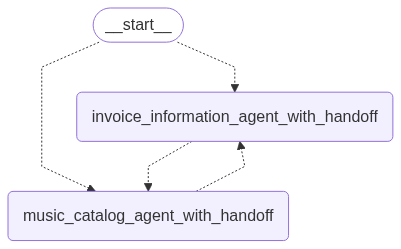

In [33]:
from langgraph_swarm import create_handoff_tool, create_swarm # Import utilities for creating swarm agents and handoff tools

# Create our handoff tools between agents.
# These are special tools that, when called by an agent, signal a transfer of control
# to another named agent within the swarm.

transfer_to_invoice_agent_handoff_tool = create_handoff_tool(
    agent_name = "invoice_information_agent_with_handoff", # The name of the target agent for this handoff
    description = "Transfer user to the invoice information agent that can help with invoice information" # Description for LLM
)

transfer_to_music_catalog_agent_handoff_tool = create_handoff_tool(
    agent_name = "music_catalog_agent_with_handoff", 
    description = "Transfer user to the music catalog agent that can help with music searches and music catalog information"
)

# Recreate our agents, but this time, add the handoff tools to their available tools.
# This allows each agent to `request` a handoff to the other when appropriate.

# First, combine the handoff tools with the existing specific tools for each agent.
invoice_tools_with_handoff = [transfer_to_music_catalog_agent_handoff_tool] + invoice_tools
music_tools_with_handoff = [transfer_to_invoice_agent_handoff_tool] + music_tools

# Recreate the invoice information agent with its original prompt and its new set of tools (including handoff).
invoice_information_agent_with_handoff = create_react_agent(
    llm,
    invoice_tools_with_handoff,
    prompt = invoice_subagent_prompt,
    name = "invoice_information_agent_with_handoff" # Give it a specific name for the swarm
)

# Recreate the music catalog agent with its original prompt and its new set of tools (including handoff).
# Note: The music catalog agent prompt is generated dynamically, as defined earlier.
music_catalog_agent_with_handoff = create_react_agent(
    llm,
    music_tools_with_handoff,
    prompt = generate_music_assistant_prompt(),
    name = "music_catalog_agent_with_handoff" # Give it a specific name for the swarm
)


# Create the swarm workflow. `create_swarm` handles the orchestration logic
# for agents to hand off to each other without a central supervisor.
swarm_workflow = create_swarm(
    agents = [invoice_information_agent_with_handoff, music_catalog_agent_with_handoff], # The agents participating in the swarm
    default_active_agent = "invoice_information_agent_with_handoff", # The agent that will be active first by default
)

# Compile the swarm graph. This makes it runnable and integrates memory.
swarm_agents = swarm_workflow.compile(
    checkpointer = checkpointer,
    store = in_memory_store
)

# Display the graph of the swarm. Notice it's different from the supervisor graph,
# showing connections for potential handoffs rather than a central hub.
show_graph(swarm_agents)

Now let's test it out! We'll give it a music-related question, but because the `default_active_agent` is set to the invoice agent, it should *hand off* to the music catalog agent.

In [34]:
# Create a new thread for this swarm test.
thread_id = uuid.uuid4()

# Ask a music-related question.
question = "Do you have any albums by the Rolling Stones?"

# Configure the invocation with the thread ID.
config = {"configurable": {"thread_id": thread_id}}

# Invoke the swarm agents. Even though the default active agent is `invoice_information_agent_with_handoff`,
# it should recognize that the query is for music and hand off to `music_catalog_agent_with_handoff`.
result = swarm_agents.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# Print the messages to observe the handoff and the final response.
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Do you have any albums by the Rolling Stones?
================================== Ai Message ==================================
Name: invoice_information_agent_with_handoff
Tool Calls:
  transfer_to_music_catalog_agent_with_handoff (chatcmpl-tool-0872f50781fd41efa13930f99be577cf)
 Call ID: chatcmpl-tool-0872f50781fd41efa13930f99be577cf
  Args:
================================= Tool Message =================================
Name: transfer_to_music_catalog_agent_with_handoff

Successfully transferred to music_catalog_agent_with_handoff
================================== Ai Message ==================================
Name: music_catalog_agent_with_handoff
Tool Calls:
  get_albums_by_artist (chatcmpl-tool-f1d12df4e6fc44a79ab7fe723a8a3081)
 Call ID: chatcmpl-tool-f1d12df4e6fc44a79ab7fe723a8a3081
  Args:
    artist: Rolling Stones
================================= Tool Message =================================
Na

## Evaluations

**Evaluations** are a quantitative and systematic way to measure the performance of your LLM applications, especially agents. They are critical because LLMs don't always behave predictably—even small changes in prompts, models, or inputs can significantly impact results. Evaluations provide a structured method to:

1.  **Identify Failures**: Pinpoint where and why your agent is not performing as expected.
2.  **Compare Versions**: Quantitatively compare different versions of your application (e.g., after prompt changes, model updates, or architectural shifts).
3.  **Build Reliability**: Iteratively improve your agent's quality and ensure it meets desired performance benchmarks.

An evaluation typically comprises three core components:

1.  **A Dataset**: A collection of test inputs and their corresponding expected outputs (ground truth). This serves as the benchmark against which your application's performance is measured.
2.  **An Application or Target Function**: The specific piece of your LLM application (e.g., an agent, a chain, or a node) that you want to evaluate. This function takes an input and returns an output.
3.  **Evaluators**: Metrics or models (often LLMs themselves, known as "LLM-as-a-judge") that score your target function's outputs against the dataset's ground truth or specific criteria.

![Evaluation Conceptual Diagram](images/evals-conceptual.png) 

There are many ways to evaluate an agent, depending on what aspect of its performance you want to measure. Today, we will cover three common types of agent evaluations:

1.  **Final Response Evaluation**: Assess the quality of the agent's ultimate answer to a user query, treating the agent as a black box.
2.  **Single Step Evaluation**: Focus on the performance of a specific, critical step within the agent's execution (e.g., whether it correctly selects a tool).
3.  **Trajectory Evaluation**: Analyze the entire sequence of steps (the "trajectory") an agent takes, assessing whether it follows the expected path of tool calls and internal reasoning.

### Evaluating The Final Response

Evaluating the final response is the most common and often the simplest way to assess an agent's overall effectiveness. It involves treating the agent as a "black box" and focusing solely on whether the final output successfully addresses the user's intent, regardless of the intermediate steps taken.

*   **Input**: The original user query.
*   **Output**: The agent's final, human-facing response.

![Final Response Evaluation](images/final-response.png) 


#### 1. Create a Dataset for Final Response Evaluation

We'll use LangSmith to create and manage our evaluation datasets. A dataset consists of `inputs` (the user questions) and `outputs` (the expected correct responses). This ground truth allows evaluators to compare the agent's generated response against what is considered correct.

In [35]:
from langsmith import Client # Import the LangSmith Client for dataset and experiment management

client = Client() # Initialize the LangSmith client. This will connect to your LangSmith account.

# Define a list of example inputs and expected outputs for our dataset.
# Each dictionary represents a test case with a 'question' (input) and a 'response' (ground truth output).
examples = [
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "response": "The Invoice ID of your most recent purchase was 342.",
    },
    {
        "question": "I'd like a refund.",
        "response": "I need additional information to help you with the refund. Could you please provide your customer identifier so that we can fetch your purchase history?",
    },
    {
        "question": "Who recorded Wish You Were Here again?",
        "response": "Wish You Were Here is an album by Pink Floyd",
    },
    { 
        "question": "What albums do you have by Coldplay?",
        "response": "There are no Coldplay albums available in our catalog at the moment.",
    },
]

dataset_name = "LangGraph 101 Multi-Agent: Final Response" # Define a name for our dataset.

# Check if the dataset already exists in LangSmith to avoid recreation.
if not client.has_dataset(dataset_name=dataset_name):
    # If not, create the dataset.
    dataset = client.create_dataset(dataset_name=dataset_name)
    # Populate the dataset with our examples.
    # `inputs` are extracted from the 'question' key, `outputs` from the 'response' key.
    client.create_examples(
        inputs=[{"question": ex["question"]} for ex in examples],
        outputs=[{"response": ex["response"]} for ex in examples],
        dataset_id=dataset.id # Associate examples with the created dataset.
    )

#### 2. Define Application Logic to be Evaluated

We need a function that encapsulates the execution of our LangGraph and returns the final response in a format suitable for evaluation. Since our graph includes a `human_input` interrupt for customer verification, we must handle this in our evaluation function. We'll simulate the user providing their customer ID (e.g., "My customer ID is 10") to allow the graph to proceed past the verification step.

In [36]:
import uuid # For generating unique thread IDs
from langgraph.types import Command # For resuming graph execution after an interrupt

graph = multi_agent_final_graph # Reference our complete, final multi-agent graph

async def run_graph(inputs: dict):
    """Run graph and track the final response for evaluation."""
    # Creating a unique thread ID for each evaluation run to ensure isolation.
    thread_id = uuid.uuid4()
    # Configuration for the graph invocation. User ID '10' is used here for a specific test scenario.
    configuration = {"configurable": {"thread_id": thread_id, "user_id" : "10"}}

    # Invoke the graph with the initial user question.
    # This invocation will likely hit the `human_input` node and interrupt if `customer_id` is not present.
    result = await graph.ainvoke({"messages": [
        { "role": "user", "content": inputs['question']}]}, config = configuration)
    
    # After the first invocation, if an interrupt occurred, resume it.
    # We explicitly provide a (simulated) customer ID to pass the verification step.
    # The `thread_id` in the config must match the initial invocation to resume the correct state.
    result = await graph.ainvoke(Command(resume="My customer ID is 10"), config={"configurable": {"thread_id": thread_id, "user_id" : "10"}})
    
    # Return the content of the last message in the conversation as the final response.
    # This is the output that will be evaluated against the dataset's `response`.
    return {"response": result['messages'][-1].content}

#### 3. Define the Evaluator for Final Response

Evaluators are functions that take the application's output, the original input, and sometimes the reference output, and return a score or feedback. We can use pre-built evaluators or define our own.

##### Using a Pre-built Evaluator (OpenEvals)
LangSmith integrates with `openevals`, a library providing ready-to-use LLM-as-a-judge evaluators. The `create_llm_as_judge` function sets up an evaluator that uses an LLM to score responses based on a given prompt (e.g., `CORRECTNESS_PROMPT`).

##### Defining a Custom Evaluator (LLM-as-a-Judge)
For more specific or nuanced evaluation criteria, you can define your own LLM-as-a-judge evaluator. This involves:
1.  **Custom Instructions**: A detailed prompt for the LLM that explains its role as a grader and the criteria for scoring.
2.  **Structured Output Schema**: A Pydantic `BaseModel` or `TypedDict` to enforce the format of the LLM's grading output (e.g., `is_correct: bool`, `reasoning: str`).
3.  **Evaluator Function**: A Python function that calls the structured LLM with the prompt, inputs, and reference outputs, then extracts the relevant score.

This approach gives you maximum flexibility over how your agent's responses are judged.

In [ ]:
from openevals.llm import create_llm_as_judge # Import the utility to create LLM-as-judge evaluators
from openevals.prompts import CORRECTNESS_PROMPT # Import a pre-defined prompt for correctness evaluation

# Create an LLM-as-judge evaluator for correctness using the pre-built `CORRECTNESS_PROMPT`.
# `feedback_key="correctness"` sets the name of the score reported in LangSmith.
# `judge=model` specifies which LLM to use for judging.
correctness_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    feedback_key="correctness",
    judge=llm,
)

# Print the content of the pre-defined correctness prompt to understand its instructions.
print(CORRECTNESS_PROMPT)

You are an expert data labeler evaluating model outputs for correctness. Your task is to assign a score based on the following rubric:

<Rubric>
  A correct answer:
  - Provides accurate and complete information
  - Contains no factual errors
  - Addresses all parts of the question
  - Is logically consistent
  - Uses precise and accurate terminology

  When scoring, you should penalize:
  - Factual errors or inaccuracies
  - Incomplete or partial answers
  - Misleading or ambiguous statements
  - Incorrect terminology
  - Logical inconsistencies
  - Missing key information
</Rubric>

<Instructions>
  - Carefully read the input and output
  - Check for factual accuracy and completeness
  - Focus on correctness of information rather than style or verbosity
</Instructions>

<Reminder>
  The goal is to evaluate factual correctness and completeness of the response.
</Reminder>

<input>
{inputs}
</input>

<output>
{outputs}
</output>

Use the reference outputs below to help you evaluate the

In [38]:
# Custom definition of LLM-as-judge instructions.
    # This prompt provides specific guidelines for the LLM acting as a grader, focusing on factual accuracy.
grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION, the GROUND TRUTH (correct) RESPONSE, and the STUDENT RESPONSE.

Here is the grade criteria to follow:
(1) Grade the student responses based ONLY on their factual accuracy relative to the ground truth answer.
(2) Ensure that the student response does not contain any conflicting statements.
(3) It is OK if the student response contains more information than the ground truth response, as long as it is factually accurate relative to the ground truth response.

Correctness:
True means that the student's response meets all of the criteria.
False means that the student's response does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# Define the schema for the LLM-as-judge's output using TypedDict.
# This ensures the grading output is structured with a reasoning and a boolean correctness score.
class Grade(TypedDict):
    """Compare the expected and actual answers and grade the actual answer."""
    reasoning: Annotated[str, ..., "Explain your reasoning for whether the actual response is correct or not."]
    is_correct: Annotated[bool, ..., "True if the student response is mostly or exactly correct, otherwise False."]

# Configure the judge LLM to output structured data according to the `Grade` schema.
# `method="json_schema"` ensures JSON-based structured output, `strict=True` enforces strict adherence.
grader_llm = llm.with_structured_output(Grade, method="json_schema", strict=True)

# Define the custom evaluator function `final_answer_correct`.
# This function takes inputs, outputs (from our `run_graph`), and reference outputs (from the dataset).
async def final_answer_correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    """Evaluate if the final response is equivalent to reference response."""
    # Construct the user prompt for the grader LLM, combining the question, ground truth, and student response.
    user = f"""QUESTION: {inputs['question']}
    GROUND TRUTH RESPONSE: {reference_outputs['response']}
    STUDENT RESPONSE: {outputs['response']}"""

    # Invoke the structured grader LLM with the system instructions and the user prompt.
    # Awaiting the async call as LLM invocations are typically async.
    grade = await grader_llm.ainvoke([{"role": "system", "content": grader_instructions}, {"role": "user", "content": user}])
    
    # Return the `is_correct` boolean from the grader's output as the evaluation score.
    return grade["is_correct"]

#### 4. Run the Final Response Evaluation

Now we're ready to run our evaluation job using the LangSmith client. The `aevaluate` method orchestrates the entire process:

1.  It fetches inputs from the specified `data` (our dataset).
2.  For each input, it calls our `run_graph` function.
3.  It then passes the `run_graph`'s output, along with the original input and dataset's reference output, to each defined `evaluator`.
4.  All results are logged and visible in your LangSmith project, providing a comprehensive report of your agent's performance.

Key parameters:
*   `run_graph`: Our target function to be evaluated.
*   `data`: The name of the dataset created in LangSmith.
*   `evaluators`: A list of evaluator functions to apply.
*   `experiment_prefix`: A prefix for the experiment name in LangSmith, useful for organizing runs.
*   `num_repetitions`: How many times to run each example. (For more robust results, typically >1)
*   `max_concurrency`: The maximum number of parallel runs (useful for speeding up evaluation).

Upon completion, you can navigate to your LangSmith project to view detailed traces and aggregated scores.

In [39]:
# Run the evaluation job asynchronously using the LangSmith client.
    # This will execute `run_graph` for each example in the dataset and apply the specified evaluators.
experiment_results = await client.aevaluate(
    run_graph,                        # The asynchronous function that runs our graph and returns its output
    data=dataset_name,                # The name of the LangSmith dataset to use for inputs and references
    evaluators=[final_answer_correct, correctness_evaluator], # List of evaluator functions to apply
    experiment_prefix="agent-Llama-e2e", # A prefix for the experiment name in LangSmith for better organization
    num_repetitions=1,                # Number of times to run each example (1 for quick testing)
    max_concurrency=5,                # Maximum concurrent runs to optimize evaluation speed
)

c:\Users\faree\Desktop\langraph_basics\.venv-langraph-basic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'agent-Llama-e2e-4f89ef54' at:
https://smith.langchain.com/o/ed92af16-6cad-4938-963c-e645d2ca645c/datasets/3dea3bcb-9c19-475a-8d22-a99de27382c1/compare?selectedSessions=5d301a6c-feaf-4fba-8dba-c23bebc27c5d




0it [00:00, ?it/s]Error running target function: Called get_config outside of a runnable context
Traceback (most recent call last):
  File "c:\Users\faree\Desktop\langraph_basics\.venv-langraph-basic\lib\site-packages\langsmith\evaluation\_arunner.py", line 1239, in _aforward
    await fn(
  File "c:\Users\faree\Desktop\langraph_basics\.venv-langraph-basic\lib\site-packages\langsmith\run_helpers.py", line 532, in async_wrapper
    function_result = await fr_coro
  File "C:\Users\faree\AppData\Local\Temp\ipykernel_9712\1774738166.py", line 15, in run_graph
    result = await graph.ainvoke({"messages": [
  File "c:\Users\faree\Desktop\langraph_basics\.venv-langraph-basic\lib\site-packages\langgraph\pregel\__init__.py", line 2788, in ainvoke
    async for chunk in self.astream(
  File "c:\Users\faree\Desktop\langraph_basics\.venv-langraph-basic\lib\site-packages\langgraph\pregel\__init__.py", line 2655, in astream
    async for _ in runner.atick(
  File "c:\Users\faree\Desktop\langraph_ba

### Evaluating a Single Step of the Agent

While end-to-end evaluation is important, it can be challenging to debug. Sometimes, an agent might fail overall, but you don't know *which* specific decision or action led to the failure. **Single-step evaluation** allows you to test individual components or critical decisions within your agent's workflow in isolation, similar to unit testing in software development.

For our multi-agent system, a critical single step is the **supervisor's routing decision**: does it correctly send the query to the music agent or the invoice agent?

*   **Input**: The specific input to that single step (e.g., the user message that the supervisor receives).
*   **Output**: The direct output of that step (e.g., the name of the agent the supervisor chose to route to).

![Single Step Evaluation](images/single-step.png) 

#### 1. Create a Dataset for Single-Step Evaluation

For single-step evaluation, our dataset's `inputs` will be the user message, and the `outputs` will be the *expected routing decision* (i.e., the name of the sub-agent that should be activated).

In [40]:
# Define examples for single-step evaluation, focusing on the supervisor's routing.
    # `messages`: The input to the supervisor (the user's query).
    # `route`: The expected output of the supervisor (the name of the sub-agent it should route to).
examples = [
    {
        "messages": "My customer ID is 1. What's my most recent purchase? and What albums does the catalog have by U2?", 
        "route": 'transfer_to_invoice_information_subagent' # Expects initial routing to invoice agent
    },
    {
        "messages": "What songs do you have by U2?", 
        "route": 'transfer_to_music_catalog_subagent' # Expects routing to music agent
    },
    {
        "messages": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?", 
        "route": 'transfer_to_invoice_information_subagent' # Expects routing to invoice agent
    },
    {
        "messages": "Who recorded Wish You Were Here again? What other albums by them do you have?", 
        "route": 'transfer_to_music_catalog_subagent' # Expects routing to music agent
    }
]


dataset_name = "LangGraph 101 Multi-Agent: Single-Step" # Name for this specific dataset.
# Check and create the dataset in LangSmith if it doesn't already exist.
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs = [{"messages": ex["messages"]} for ex in examples],
        outputs = [{"route": ex["route"]} for ex in examples],
        dataset_id=dataset.id
    )

#### 2. Define the Application Logic to Evaluate (Single Step)

To evaluate only the supervisor's routing, we need to run our `supervisor_prebuilt` graph but *interrupt* its execution immediately after the supervisor makes its routing decision, before any sub-agents are actually invoked. LangGraph's `interrupt_before` argument is perfect for this.

The `interrupt_before` parameter tells the graph to pause execution right before entering the specified nodes. In this case, we want to pause before `music_catalog_subagent` or `invoice_information_subagent` are invoked. This allows us to inspect the state and determine what the supervisor decided to do.

In [41]:
async def run_supervisor_routing(inputs: dict):
    """Runs the supervisor graph up to the point of routing and returns the chosen route."""
    # Invoke the `supervisor_prebuilt` graph.
    # `interrupt_before` specifies that the graph should pause execution just before entering 
    # either the music or invoice sub-agent nodes. This captures the routing decision.
    # A dummy `user_id` and `thread_id` are provided for configuration, as the supervisor itself doesn't need real verification here.
    result = await supervisor_prebuilt.ainvoke(
        {"messages": [HumanMessage(content=inputs['messages'])]},
        interrupt_before=["music_catalog_subagent", "invoice_information_subagent"],
        config={"configurable": {"thread_id": uuid.uuid4(), "user_id" : "10"}}
    )
    
    # The name of the last message (which is typically the `tool_call` or `message` that represents the routing decision)
    # should correspond to the name of the next chosen sub-agent. This is how the supervisor indicates its routing.
    return {"route": result["messages"][-1].name}

#### 3. Define the Evaluator for Single Step

For this single-step evaluation, a simple exact match evaluator is sufficient. It will check if the `route` output by our `run_supervisor_routing` function exactly matches the `route` defined in our dataset's `reference_outputs`.

In [42]:
def correct(outputs: dict, reference_outputs: dict) -> bool:
    """Evaluator function to check if the agent chose the correct route."""
    # Compares the 'route' returned by our `run_supervisor_routing` function
    # with the 'route' specified in the ground truth dataset.
    return outputs['route'] == reference_outputs["route"]

#### 4. Run the Single Step Evaluation

Now we execute the single-step evaluation using `client.aevaluate`, similar to the final response evaluation, but with our specialized function and dataset.

In [43]:
experiment_results = await client.aevaluate(
    run_supervisor_routing,           # Our function that runs only the supervisor routing step
    data=dataset_name,                # The dataset specifically for single-step routing evaluation
    evaluators=[correct],
    experiment_prefix="agent-Llama-singlestep",
    max_concurrency=5,
)

View the evaluation results for experiment: 'agent-Llama-singlestep-792e2bf1' at:
https://smith.langchain.com/o/ed92af16-6cad-4938-963c-e645d2ca645c/datasets/92ce1add-8191-438d-b9f1-456436efc7d6/compare?selectedSessions=06f7c89b-ba86-4ed2-81e8-a233d73955fd




4it [00:02,  1.49it/s]


### Evaluating the Trajectory of the Agent

**Trajectory evaluation** takes a deeper look into the agent's internal workings. Instead of just assessing the final output or a single step, it evaluates the entire sequence of steps (the "trajectory") an agent takes to arrive at its answer. This is particularly useful for complex agents where the *process* of reaching a solution is as important as the solution itself (e.g., ensuring a specific set of tools are used in a particular order).

*   **Input**: The initial user query to the overall agent.
*   **Output**: A detailed list of all nodes/steps visited during the agent's execution.

![Trajectory Evaluation](images/trajectory.png) 


#### 1. Create a Dataset for Trajectory Evaluation

For trajectory evaluation, our dataset will contain the user `question` as input and an ordered list of `trajectory` (the expected sequence of node names) as the ground truth output.

In [44]:
# Define examples for trajectory evaluation.
    # `question`: The user's input.
    # `trajectory`: The expected ordered list of node names visited by the graph.
examples = [
    {
        "question": "My customer ID is 1. What's my most recent purchase? and What albums does the catalog have by U2?",
        "trajectory": ["verify_info", "load_memory", "supervisor", "create_memory"], # Expected path when customer ID is provided
    },
    {
        "question": "What songs do you have by U2?",
        "trajectory": ["verify_info", "human_input", "verify_info", "load_memory", "supervisor", "create_memory"], # Expected path with initial verification and resume
    },
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "trajectory": ["verify_info", "load_memory", "supervisor", "create_memory"], # Expected path when customer ID is provided implicitly
    },
    {
        "question": "Who recorded Wish You Were Here again? What other albums by them do you have?",
        "trajectory": ["verify_info", "human_input", "verify_info", "load_memory", "supervisor", "create_memory"], # Another example with initial verification and resume
    },
]

dataset_name = "LangGraph 101 Multi-Agent: Trajectory Eval" # Name for this dataset.

# Check and create the dataset in LangSmith if it doesn't already exist.
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"question": ex["question"]} for ex in examples],
        outputs=[{"trajectory": ex["trajectory"]} for ex in examples],
        dataset_id=dataset.id
    )

#### 2. Define the Application Logic to Evaluate (Trajectory)

To capture the full trajectory, we will use `graph.astream(stream_mode="debug")`. The `debug` stream mode yields detailed `chunk` objects for each step in the graph, including the `task` chunks which contain the name of the node being executed. We'll collect these node names into a list to form the actual trajectory.

Similar to the final response evaluation, we need to handle the `human_input` interrupt by resuming the graph with dummy input.

In [45]:
graph = multi_agent_final_graph # Reference our complete multi-agent graph

async def run_graph(inputs: dict) -> dict:
    """Run graph and track the trajectory it takes along with the final response."""
    trajectory = [] # List to store the names of nodes visited
    thread_id = uuid.uuid4() # Unique ID for the current thread
    # Configuration for the graph invocation, including a dummy user_id for verification step.
    configuration = {"configurable": {"thread_id": thread_id, "user_id" : "10"}}

    # First, run the graph for the initial question. `astream` allows us to iterate through chunks.
    # `stream_mode="debug"` provides detailed information about each step, including node names.
    async for chunk in graph.astream({"messages": [
            {
                "role": "user",
                "content": inputs['question'],
            }
        ]}, config = configuration, stream_mode="debug"):
        # Check if the chunk type is 'task' (indicating a node execution).
        if chunk['type'] == 'task':
            # Append the name of the executed node to our trajectory list.
            trajectory.append(chunk['payload']['name'])

    # If the graph paused for human input, resume it with a dummy customer ID.
    async for chunk in graph.astream(Command(resume="My customer ID is 10"), config = configuration, stream_mode="debug"):
        if chunk['type'] == 'task':
            trajectory.append(chunk['payload']['name'])
            
    # Return the collected trajectory list.
    return {"trajectory": trajectory}

#### 3. Define the Evaluator for Trajectory

For trajectory evaluation, we'll define two custom evaluators:

1.  **`evaluate_exact_match`**: This simple evaluator checks if the `actual trajectory` exactly matches the `expected trajectory` from the dataset. It provides a binary score (True/False).
2.  **`evaluate_extra_steps`**: This more sophisticated evaluator counts the number of "unmatched" or "extra" steps taken by the agent that were not present in the reference trajectory. This can indicate inefficiency or unexpected behavior.

In [46]:
def evaluate_exact_match(outputs: dict, reference_outputs: dict):
    """Evaluate whether the trajectory exactly matches the expected output"""
    return {
        "key": "exact_match", # The key for this evaluation metric in LangSmith
        "score": outputs["trajectory"] == reference_outputs["trajectory"] # True if trajectories are identical
    }

def evaluate_extra_steps(outputs: dict, reference_outputs: dict) -> dict:
    """Evaluate the number of unmatched steps in the agent's output trajectory compared to the reference."""
    i = j = 0 # Pointers for reference trajectory (i) and actual output trajectory (j)
    unmatched_steps = 0 # Counter for steps in output not found in reference sequence

    # Iterate through both trajectories to find matches and count mismatches.
    while i < len(reference_outputs['trajectory']) and j < len(outputs['trajectory']):
        if reference_outputs['trajectory'][i] == outputs['trajectory'][j]:
            i += 1  # Match found, move to the next step in reference trajectory
        else:
            unmatched_steps += 1  # Step in output is not the expected one, count as unmatched
        j += 1  # Always move to the next step in outputs trajectory

    # After the loop, if there are remaining steps in the output trajectory,
    # they are all considered unmatched (extra steps taken by the agent).
    unmatched_steps += len(outputs['trajectory']) - j

    return {
        "key": "unmatched_steps", # The key for this evaluation metric
        "score": unmatched_steps, # The count of unmatched steps
    }

#### 4. Run the Trajectory Evaluation

Finally, we run the trajectory evaluation using our specialized `run_graph` function and the two custom trajectory evaluators. The results will be uploaded to LangSmith, where you can analyze the sequence of node executions and compare them against your expected paths.

In [47]:
experiment_results = await client.aevaluate(
    run_graph,                        # Our function that collects the full trajectory
    data=dataset_name,                # The dataset specifically for trajectory evaluation
    evaluators=[evaluate_extra_steps, evaluate_exact_match], # Our custom trajectory evaluators
    experiment_prefix="agent-Llama-trajectory", # Prefix for the experiment name in LangSmith
    num_repetitions=1,
    max_concurrency=4,
)

View the evaluation results for experiment: 'agent-Llama-trajectory-fb6c2330' at:
https://smith.langchain.com/o/ed92af16-6cad-4938-963c-e645d2ca645c/datasets/cc3b61d8-554c-4088-8f20-8112bd53160a/compare?selectedSessions=e92c45a3-bee1-41ee-ae6f-4209b7fc36de


